# Transformée en z inverse (pôles d'ordre 1 ou 2)

Les packages utilisés :

In [1]:
import sympy as sp
import numpy as np
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from IPython.display import display, Math

## Calcul symbolique avec sympy

On considère un exemple $H(z)$ de transformée en $z$, avec les zéros et les pôles (ordre 1 ou 2) sous forme littérale.

In [2]:
zm1, n, G = sp.symbols('z^{-1}, n, G')
P = sp.IndexedBase('P')
Z = sp.IndexedBase('Z')
Gn = [(G, 5)]
Pn = [(P[1], 0.5), (P[2], 0.9), (P[3], 0.6)]
OPn = [2, 2, 2]
Zn = [(Z[1], 0.1), (Z[2], 0.2)]
OZn = [1, 1]

Les applications numériques pourront être effectuées via la méthode **subs**.

In [3]:
H = Gn[0][0]
for k in range(len(Pn)):
    H = H/(1 - Pn[k][0]*zm1)**OPn[k]
for k in range(len(Zn)):
    H = H*(1 - Zn[k][0]*zm1)**OZn[k]
display(Math('H(z)='+sp.latex(H)))
display(Math('H(z)='+sp.latex(H.subs(Pn).subs(Zn).subs(Gn))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

La décomposition en élément simple avec la méthode **apart**, après application numérique, ne fonctionne pas pour l'exemple considéré !

In [4]:
display(H.subs(Gn).subs(Pn).subs(Zn).apart())

0.759878419452888*(0.02*z^{-1}**2 - 0.3*z^{-1} + 1.0)/(0.0110790273556231*z^{-1}**6 - 0.105866261398176*z^{-1}**5 + 0.417036474164134*z^{-1}**4 - 0.866261398176292*z^{-1}**3 + 1.0*z^{-1}**2 - 0.60790273556231*z^{-1} + 0.151975683890578)

Il faut donc effectuer la décomposition avec la forme littérale, puis réaliser l'application numérique a posteriori. On envisage juste le cas où les pôles ont un ordre de multiplicité égal à 1 ou 2.

In [5]:
def inv_z(Gn, Zn, OZn, Pn, OPn, zm1, n):
    A = sp.IndexedBase('A')
    y = sp.symbols('y')
    An, h, tz = [], 0, 0
    polyP = sp.Poly(Gn[0][1], zm1)
    for m in range(len(Zn)):
        polyP = polyP*(1 - Zn[m][1]*zm1)**OZn[m]
    for k in range(len(Pn)):
        polyB = sp.Poly(1, zm1)
        for m in range(len(Pn)):
            if m != k:
                polyB = polyB*(1 - Pn[m][1]*zm1)**OPn[m]
        polyB = sp.Poly(polyB.subs(zm1, (1-y)/Pn[k][1]), y)
        polyR = sp.Poly(polyP.subs(zm1, (1-y)/Pn[k][1]), y)
        polyQ = sp.Poly(0, y)
        for m in range(OPn[k]):
            q = polyR.coeff_monomial(y**m)/polyB.coeff_monomial(y**0)
            polyQ = sp.Poly(polyQ+q*y**m, y)
            polyR = sp.Poly(polyR-q*polyB*y**m, y)
        display(Math(sp.latex(Pn[k][0]) + '=' +
                f'{Pn[k][1]}'+'\\quad\\text{ordre}='+f'{OPn[k]}'))
        display(Math('R(y)='+sp.latex(polyR.as_expr().n(4))))
        display(Math('Q(y)='+sp.latex(polyQ.as_expr().n(4))))
        if OPn[k] == 1:
            An.append((A[Pn[k][0].indices[0], 1], polyQ.coeff_monomial(y**0)))
            tz = tz + A[Pn[k][0].indices[0], 1]/(1-zm1*Pn[k][0])
            h = h + A[Pn[k][0].indices[0], 1]*(Pn[k][0]**n)
        elif OPn[k] == 2:
            An.append((A[Pn[k][0].indices[0], 2], polyQ.coeff_monomial(y**0)))
            tz = tz + A[Pn[k][0].indices[0], 2]/(1-zm1*Pn[k][0])**2
            h = h + (n+1)*A[Pn[k][0].indices[0], 2]*(Pn[k][0]**n)
            An.append((A[Pn[k][0].indices[0], 1], polyQ.coeff_monomial(y**1)))
            tz = tz + A[Pn[k][0].indices[0], 1]/(1-zm1*Pn[k][0])
            h = h + A[Pn[k][0].indices[0], 1]*(Pn[k][0]**n)
    return An, h, tz

In [6]:
An, h, tz = inv_z(Gn, Zn, OZn, Pn, OPn, zm1, n)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
display(An)
display(Pn)
display(Math('h(n)='+sp.latex(h)))
display(Math('H(z)='+sp.latex(tz)))

[(A[1, 2], 93.7499999999973),
 (A[1, 1], 1632.81249999992),
 (A[2, 2], 157.500000000000),
 (A[2, 1], -959.062500000002),
 (A[3, 2], 400.000000000040),
 (A[3, 1], -1320.00000000013)]

[(P[1], 0.5), (P[2], 0.9), (P[3], 0.6)]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Les coefficients des polynômes en $z^{-1}$ du numérateur $N(z)$ et du dénominateur $D(z)$ sont récupérés sous forme numérique selon les puissances croissantes de $z^{-1}$.

In [8]:
N = sp.fraction(H)[0].subs(Zn).subs(Gn)
D = sp.fraction(H)[1].subs(Pn)
coeffN = np.array([sp.Poly(N, zm1).coeff_monomial(zm1**k)
                  for k in range(sum(OZn)+1)], dtype=complex).real
coeffD = np.array([sp.Poly(D, zm1).coeff_monomial(zm1**k)
                  for k in range(sum(OPn)+1)], dtype=complex).real
display(Math('N(z)='+sp.latex(sp.Poly(N, zm1).as_expr())))
print('coeffN = ', coeffN)
display(Math('D(z)='+sp.latex(sp.Poly(D, zm1).as_expr())))
print('coeffD = ', coeffD)

<IPython.core.display.Math object>

coeffN =  [ 5.  -1.5  0.1]


<IPython.core.display.Math object>

coeffD =  [ 1.     -4.      6.58   -5.7     2.7441 -0.6966  0.0729]


## Calcul numérique avec la fonction **lfilter** de scipy

Les coefficients des polynômes en $z^{-1}$ du numérateur et du dénominateur sont cette fois récupérés selon les puissances croissantes de $z^{-1}$. Il n'est pas nécessaire de réaliser la décomposition en éléments simples et il suffit d'envoyer en entrée une impulsion numérique $\delta(n)$.

In [9]:
N = 25
delta = np.zeros(N)
tn = np.arange(N)
delta[0] = 1

In [10]:
h_scipy = lfilter(coeffN, coeffD, delta)

## Calcul numérique avec les résultats obtenus avec sympy

L'application numérique s'effectue à partir de l'expression littérale de $h(n)$.

In [11]:
display(h)
h_sympy = np.real(sp.lambdify(n, h.subs(Pn).subs(An), 'numpy')(tn))

(n + 1)*A[1, 2]*P[1]**n + (n + 1)*A[2, 2]*P[2]**n + (n + 1)*A[3, 2]*P[3]**n + A[1, 1]*P[1]**n + A[2, 1]*P[2]**n + A[3, 1]*P[3]**n

## Bilan

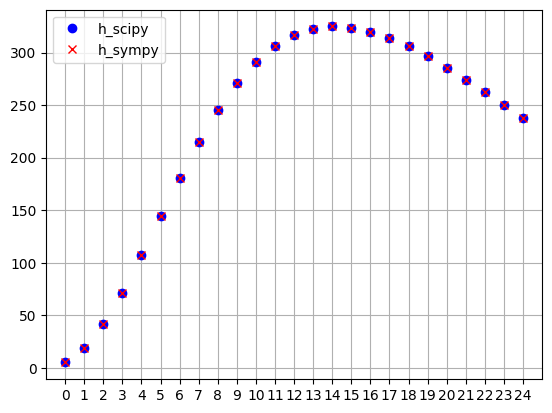

In [12]:
plt.plot(tn, h_scipy, 'bo', label='h_scipy')
plt.plot(tn, h_sympy, 'rx', label='h_sympy')
plt.grid('on')
plt.xlim([-1, N])
plt.xticks(np.arange(N))
plt.legend()
plt.show()